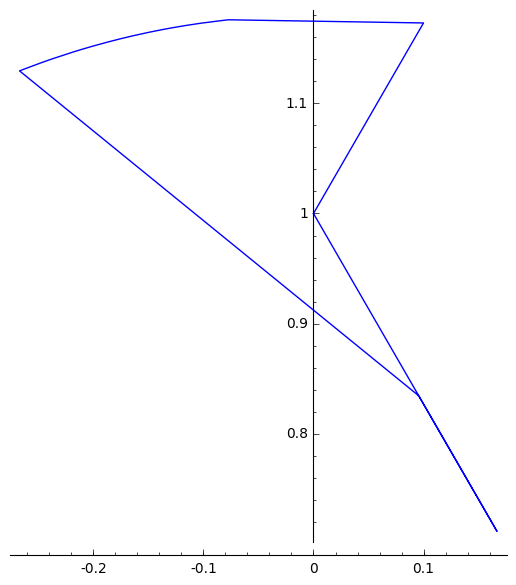

In [24]:
#M.G. 5/23/17, Most recent update 6/6/17, Currently functional, but producing unanticipated graphs (with parametric plot)

t = var('t') #Global time variable
#f(x) = sqrt(3)*x + 1 #Gives y-coordinate as a function of x-coordinate for e3 trajectory w/ initial conditions x0 = 0, y0 = 1
z(x, y) = x + y*I
dx_init, dy_init, dx_fin, dy_fin, dm, dc0, dc1, dtf = var('dx_init dy_init dx_fin dy_fin dm dc0 dc1 dtf') #Dummy variables, utilized for substitution
assume(dc1 != 0) #Assumptions made for successful integration
assume(dtf > 0)

def linfrac(x, y): #Mobius transformation R.z, where z = x + yi, and R as defined in paper
    a = N(cos(pi/3)); b = N(-sin(pi/3)); c = N(sin(pi/3)); d = N(cos(pi/3)); z = x + y*I
    return N((a*z + b)/(c*z + d))

def inverse_linfrac(x, y):
    a = N(cos(-pi/3)); b = N(-sin(-pi/3)); c = N(sin(-pi/3)); d = N(cos(-pi/3)); z = x + y*I
    return N((a*z + b)/(c*z + d))

def e3(x_init, y_init, t):
    m = N(1/sqrt(3)); c0 = N(x_init + m); c1 = N(y_init/c0)
    x = -m + c0*e^(c1*t)
    y = c0*c1*e^(c1*t)
    z = x + y*I
    return N(z)

def e2(x_init, y_init, t):
    m = N(-1/sqrt(3)); c0 = N(x_init + m); c1 = N(y_init/c0)
    x = -m + c0*e^(c1*t)
    y = c0*c1*e^(c1*t)
    z = x + y*I
    return N(z)

def e1(x_init, y_init, t): #Utilizing the Mobius transformation, translate points on e1 trajectory into points on e3, then map back to e1; true e1 parametrization is quite complex
    lz_init = linfrac(x_init, y_init)
    lz_t = e3(lz_init.real(), lz_init.imag(), t)
    return N(inverse_linfrac(lz_t.real(), lz_t.imag()))
    
def get_time(x_init, y_init, x_fin, y_fin): #y_fin only used to determine the sign of m
    if y_init <= y_fin:
        m = 1/sqrt(3) 
    else:
        m = -1/sqrt(3)
    s = solve(x_fin == -m + (x_init + m)*e^((y_init/(x_init + m))*t), t)
    return s

time_formula = solve(dx_fin == -dm + (dx_init + dm)*e^((dy_init/(dx_init + dm))*t), t)[0].right().full_simplify()

def get_time2(x_init, y_init, x_fin, y_fin): #y_fin only used to determine the sign of m
    if y_init <= y_fin:
        m = 1/sqrt(3) 
    else:
        m = -1/sqrt(3)
    s = time_formula.substitute(dx_init == x_init, dy_init == y_init, dx_fin == x_fin, dy_fin == y_fin, dm == m)
    return s
    
def control_trajectory(x1): #The input here should be the terminal x-point you choose after initially traveling along e3; everything is determined from here
    x0 = 0; y0 = 1
    z0 = z(x0, y0)
    y1 = sqrt(3)*x1 + 1
    z1 = z(x1, y1)
    t1 = get_time2(x0, y0, x1, y1)
    x2 = -x1; y2 = y1 #By symmetry
    z2 = z(x2, y2)
    Rz1 = linfrac(x1, y1)
    Rz2 = linfrac(x2, y2)
    Rx1 = Rz1.real(); Ry1 = Rz1.imag()
    Rx2 = Rz2.real(); Ry2 = Rz2.imag()
    t2 = get_time2(Rx1, Ry1, Rx2, Ry2)
    x3 = x0; y3 = y0 #Notational convenience; there is no fundamental difference between (x3, y3) and (x0, y0)
    z3 = z(x3, y3)
    t3 = get_time2(x2, y2, x3, y3)
    solz = [z1, z2, z3]
    solt = [t1, t2, t3]
    sol = [N(solz[0]), N(solt[0]), N(solz[1]), N(solt[1]), N(solz[2]), N(solt[2])] #It takes time ti to get from z(i-1) to zi, i = 1, 2, 3
    return sol #read sol as three sets of ordered pairs: (solz[j], solt[j]), j = 0, 1, 2; we do not return it formatted as such in order to retain ease of access to elements

def t1(x1):
    return control_trajectory(x1)[1]

def t2(x1):
    return control_trajectory(x1)[3]

def t3(x1):
    return control_trajectory(x1)[5]

#def x(x_init, y_init, x_fin, y_fin, t):
#    t1 = 
#    if 0 <= t <= get_time(x_init, y_init, x_fin, y_fin, t)[0].right():
#        return N(-m + (x_init + m)*e^((y_init/(x_init + m))*t))
#    elif get_time(x_init, y_init, x_fin, y_fin, t)[0].right() < t < 

def path(x1, t):
    control = control_trajectory(x1)
    t1 = control[1]; t2 = control[3]; t3 = control[5]; z1 = control[0]; z2 = control[2]; z3 = control[4]
    if 0 <= t <= t1:
        return e3(0, 1, t)
    elif t1 < t < t1 + t2:
        return e1(z1.real(), z1.imag(), t)
    elif t1 + t2 <= t <= t1 + t2 + t3:
        return e2(z2.real(), z2.imag(), t)
    else:
        return 0 + 1*I
        
x(t) = -dm + dc0*e^(dc1*t); y(t) = dc0*dc1*e^(dc1*t)        
Integral = (3/2)*integral((x(t)^2 + y(t)^2 + 1)/y(t), t, 0, dtf)
    
def cost(x1):
    control = control_trajectory(x1)
    t1 = control[1]; t2 = control[3]; t3 = control[5]; z1 = control[0]; z2 = control[2]; z3 = control[4]
    x0 = 0; y0 = 1; m = N(1/sqrt(3)); n = -m
    y1 = z1.imag(); x2 = z2.real(); y2 = z2.imag(); x3 = z3.real(); y3 = z3.imag()
    Rz1 = linfrac(x1, y1); Rz2 = linfrac(x2, y2)
    Rx1 = Rz1.real(); Ry1 = Rz1.imag(); Rx2 = Rz2.real(); Ry2 = Rz2.imag()
    Integral1 = Integral.substitute(dm == m, dc0 == x0 + m, dc1 == y0/(x0 + m), dtf == t1)
    Integral2 = Integral.substitute(dm == m, dc0 == Rx1 + m, dc1 == Ry1/(Rx1 + m), dtf == t2)
    Integral3 = Integral.substitute(dm == n, dc0 == x2 + n, dc1 == y2/(x2 + n), dtf == t3)
    total_cost = Integral1 + Integral2 + Integral3
    print(Integral1); print(Integral2); print(Integral3)
    return total_cost
    

#a = 1/sqrt(3) - .1
#for i in range(0, 1000):
#    print(z1(0, 1, i/1000))

#parametric_plot((lambda t: e1(a, 3, t).real(), lambda t: e1(a, 3, t).imag()), (t, 0, .2))
#print(control_trajectory(0.1))
#parametric_plot((lambda t: z3(a, 3, t).real(), lambda t: z3(a, 3, t).imag()), (t, 0, .2))
#control_trajectory(0.1)
#for i in range(0, 1000):
#    print(N(get_time(0, 1, i, sqrt(3)*i + 1, t)[0].right()))
def function():
    for i in range(1, 5):
        print(control_trajectory(i))
        
#timeit('cost(0.1)')
#get_time2(0, 1, 0.1, y(0.1))
#control_trajectory(0.1)
#cost(0.1)
parametric_plot((lambda t: path(0.1, t).real(), lambda t: path(0.1, t).imag()), (t, 0, 1))